In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [2]:
list_id = []
list_latitude = []
list_longitude = []
list_elevation = []
list_state = []

with open('data/ghcnd-stations.txt', 'r') as f:
    for line in f:
        # split the spaces
        list_line = line.split(' ')
        # delete the empty characters
        list_line = [line for line in list_line if line != '']

        # mapping file has the following columns:
        # id, latitude, longitude, elevation, state, name, gsn flag, wmo id
        # let's say that we don't care about name, gsn flag and wmo id
        # so we just want to keep the first 5 fields
        # we keep the state just for US contries, for other countries we put the first
        # two letters of the id
        if list_line[0][:2] == 'US':
            list_line = list_line[:5]
            state = list_line[4]
        else:
            list_line = list_line[:4]
            state = list_line[0][:2]
        
        list_id.append(list_line[0])
        list_latitude.append(list_line[1])
        list_longitude.append(list_line[2])
        list_elevation.append(list_line[3])
        list_state.append(state)


mapping_df = pd.DataFrame({
    'id': list_id,
    'latitude': list_latitude,
    'longitude': list_longitude,
    'elevation': list_elevation,
    'state': list_state
})

mapping_df['latitude'] = mapping_df['latitude'].astype(float)
mapping_df['longitude'] = mapping_df['longitude'].astype(float)
mapping_df['elevation'] = mapping_df['elevation'].astype(float)

mapping_df = mapping_df.set_index('id')



In [6]:
files = os.listdir('data')
files = [f for f in files if (('.csv' in f) and ('.gz' not in f))]

In [10]:
def format_dataset(filename):
    
    print(f"Working on file {filename}")

    dataset = pd.read_csv(filename, header=None, dtype={1: str, 7: str})

    dataset.columns = ['id', 'date', 'element', 'value', 'm_flag', 'q_flag', 's_flag', 'obs_time']
    dataset = dataset.loc[dataset['q_flag'].isna()]
    dataset = dataset.loc[dataset['element'].isin(['TMIN', 'TMAX'])]

    dataset['datetime'] = pd.to_datetime(dataset['date'], format='%Y%m%d')
    dataset = dataset[['datetime', 'id', 'value', 'element']]

    dataset = dataset.set_index(['datetime', 'id', 'element'])
    dataset = dataset['value'].unstack()

    dataset = dataset / 10 # temperature is in decimals of celsius degrees
    dataset = dataset.sort_index()

    # just keep US data
    us_ids = [a for a in list(dataset.index.get_level_values('id').unique()) if 'US' in a]
    dataset = dataset.loc[dataset.index.get_level_values('id').isin(us_ids)]

    return dataset

In [11]:
historical_temperatures = []

for file in files:
    temperature = format_dataset('data/' + file)

    historical_temperatures.append(temperature)

historical_temperatures = pd.concat(historical_temperatures)


Working on file data/2020.csv
Working on file data/2021.csv
Working on file data/2022.csv
Working on file data/2023.csv
Working on file data/2024.csv


In [4]:
historical_temperatures = historical_temperatures.join(mapping_df)

In [6]:
historical_temperatures.to_parquet('historical_temperatures.parquet')

In [24]:
historical_temperatures

element                 TMAX  TMIN
datetime   id                     
2020-01-01 USC00010063  13.9  -2.8
           USC00010160  13.9  -1.1
           USC00010178  12.8  -1.7
           USC00010260  11.7  -2.2
           USC00010390  13.3   0.0
...                      ...   ...
2024-06-05 USW00014838  26.1  12.2
           USW00014924  21.7  12.2
           USW00022508  28.3  21.7
           USW00024020  25.0  11.7
           USW00025322  15.6   7.8

[11802244 rows x 2 columns]

<Axes: xlabel='datetime'>

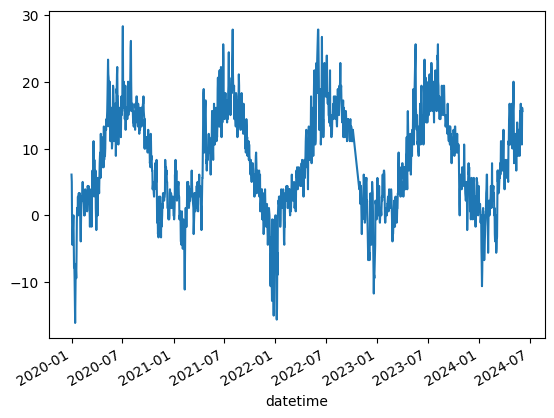

In [26]:
historical_temperatures['TMAX'].unstack()['USW00025322'].resample('D').asfreq().dropna().plot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

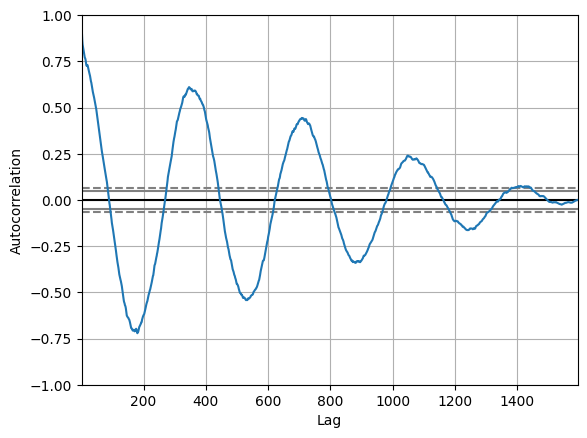

In [27]:
pd.plotting.autocorrelation_plot(historical_temperatures['TMAX'].unstack()['USW00025322'].resample('D').asfreq().dropna())

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

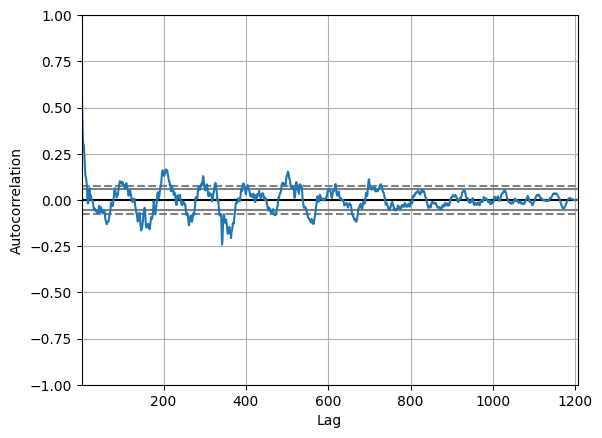

In [30]:
pd.plotting.autocorrelation_plot(historical_temperatures['TMAX'].unstack()['USW00025322'].resample('D').asfreq().diff(365).dropna())

In [35]:
adfuller(historical_temperatures['TMAX'].unstack()['USW00025322'].resample('D').asfreq().dropna(),
         maxlag=500)

(-3.2014923267375983,
 0.019898459829589814,
 11,
 1582,
 {'1%': -3.4344902922617484,
  '5%': -2.8633686930199795,
  '10%': -2.567743562326489},
 5128.834030651477)

In [36]:
adfuller(historical_temperatures['TMAX'].unstack()['USW00025322'].resample('D').asfreq().diff(365).dropna(),
         maxlag=500)

(-8.229160774250094,
 6.129338407224515e-13,
 5,
 1200,
 {'1%': -3.435811119579282,
  '5%': -2.8639515467824075,
  '10%': -2.5680539506944444},
 3782.317223352459)

In [42]:
historical_temperatures['temp_diff'] = historical_temperatures['TMAX'] - historical_temperatures['TMIN']
historical_temperatures['temp_mid'] = (historical_temperatures['TMAX'] + historical_temperatures['TMIN']) / 2

<Axes: xlabel='datetime'>

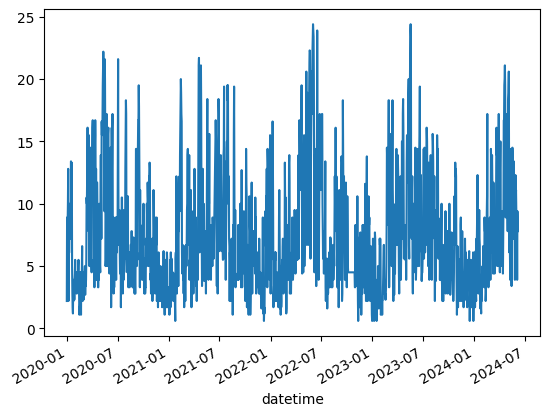

In [38]:
historical_temperatures['temp_diff'].unstack()['USW00025322'].resample('D').asfreq().dropna().plot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

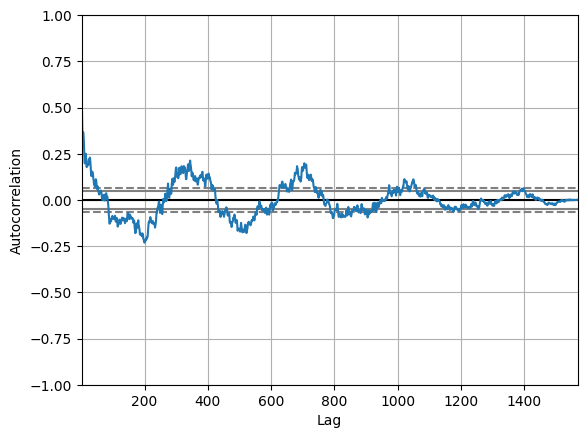

In [39]:
pd.plotting.autocorrelation_plot(historical_temperatures['temp_diff'].unstack()['USW00025322'].resample('D').asfreq().dropna())

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

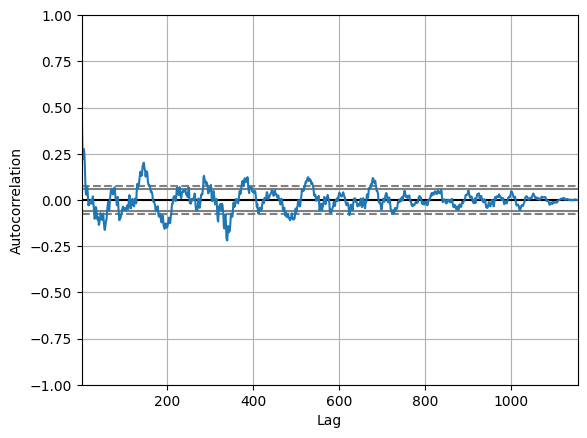

In [47]:
pd.plotting.autocorrelation_plot(historical_temperatures['temp_diff'].unstack()['USW00025322'].resample('D').asfreq().diff(365).dropna())

<Axes: >

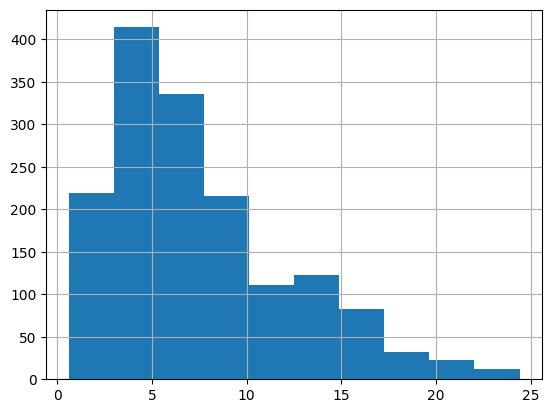

In [40]:
historical_temperatures['temp_diff'].unstack()['USW00025322'].resample('D').asfreq().dropna().hist()

<Axes: >

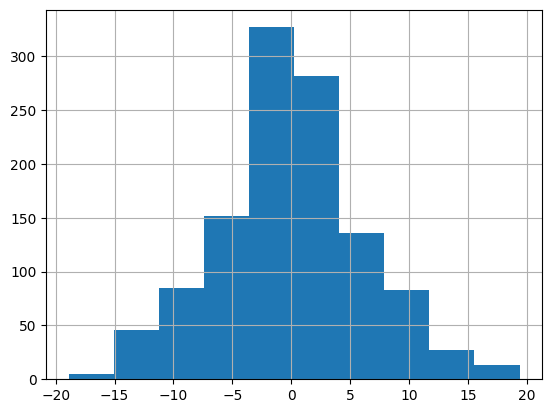

In [49]:
historical_temperatures['temp_diff'].unstack()['USW00025322'].resample('D').asfreq().diff(365).dropna().hist()

In [51]:
adfuller(historical_temperatures['temp_diff'].unstack()['USW00025322'].resample('D').asfreq().dropna())

(-6.447584518533818,
 1.5520189143718476e-08,
 12,
 1556,
 {'1%': -3.4345595891554566,
  '5%': -2.863399278674411,
  '10%': -2.5677598491451947},
 8146.522600042734)

In [52]:
adfuller(historical_temperatures['temp_diff'].unstack()['USW00025322'].resample('D').asfreq().diff(365).dropna())

(-8.089599527166088,
 1.389743387449638e-12,
 9,
 1146,
 {'1%': -3.4360690296267338,
  '5%': -2.864065327292836,
  '10%': -2.568114547237679},
 6802.7860580433935)